Lors du TP fait en salle, nous avons réalisé un clustering sur le jeu de données Digit. Pour ce faire, nous avons d’abord standardisé les données avec MinMaxScaler puis réduit leur dimension à l’aide de la PCA, avant d’évaluer les résultats selon quatre métriques principales : homogénéité, complétude, V‑mesure et coefficient de silhouette.

Dans cette partie, nous **explorerons d’autres méthodes de standardisation (StandardScaler et RobustScaler) et comparerons également les performances sans réduction de dimension, afin de mesurer l’impact respectif de la standardisation et de la réduction.**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from time import time

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

# 1. Chargement des données
digits = load_digits()
X, y = digits.data, digits.target
n_digits = len(np.unique(y))

# 2. Définitions des scalers et des réductions
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

reductions = {
    'None': lambda X: X,
    'PCA(0.99)': PCA(n_components=0.99),
    'PCA(2)': PCA(n_components=2)
}

# 3. Grille d'hyper‑paramètres pour KMeans
inits      = ['k-means++', 'random']
n_init_grid  = [4, 10]
max_iter_grid = [300, 600]

# 4. Fonction d’évaluation
def eval_kmeans(X, y, init, n_init, max_iter):
    km = KMeans(
        n_clusters=n_digits, init=init,
        n_init=n_init, max_iter=max_iter,
        random_state=0
    )
    t0 = time()
    km.fit(X)
    dt = time() - t0

    labels = km.labels_
    return {
        'init': init,
        'n_init': n_init,
        'max_iter': max_iter,
        'time_sec': round(dt, 3),
        'inertia': int(km.inertia_),
        'homo': round(metrics.homogeneity_score(y, labels), 3),
        'compl': round(metrics.completeness_score(y, labels), 3),
        'v-meas': round(metrics.v_measure_score(y, labels), 3),
        'ARI': round(metrics.adjusted_rand_score(y, labels), 3),
        'silhouette': round(metrics.silhouette_score(X, labels, sample_size=300), 3)
    }

# 5. Boucle sur toutes les configurations
results = []
for scaler_name, scaler in scalers.items():
    Xs = scaler.fit_transform(X)
    for red_name, red in reductions.items():
        # appliquer la réduction
        if red_name != 'None':
            Xr = red.fit_transform(Xs)
        else:
            Xr = Xs

        for init in inits:
            for n_init in n_init_grid:
                for max_it in max_iter_grid:
                    res = eval_kmeans(Xr, y, init, n_init, max_it)
                    res.update({
                        'scaler': scaler_name,
                        'reduction': red_name
                    })
                    results.append(res)

# 6. Mise en DataFrame et affichage
df = pd.DataFrame(results)
display(df.sort_values(by='silhouette', ascending=False).head(10))


,init,n_init,max_iter,time_sec,inertia,homo,compl,v-meas,ARI,silhouette,scaler,reduction
67,k-means++,10,600,1.426,1653,0.237,0.292,0.262,0.106,0.469,Robust,PCA(2)
64,k-means++,4,300,0.555,1653,0.237,0.292,0.262,0.106,0.447,Robust,PCA(2)
66,k-means++,10,300,1.398,1653,0.237,0.292,0.262,0.106,0.442,Robust,PCA(2)
65,k-means++,4,600,0.584,1653,0.237,0.292,0.262,0.106,0.439,Robust,PCA(2)
23,random,10,600,1.428,223,0.523,0.527,0.525,0.388,0.409,MinMax,PCA(2)
40,k-means++,4,300,0.588,2815,0.459,0.471,0.465,0.326,0.406,Standard,PCA(2)
20,random,4,300,0.588,223,0.523,0.527,0.525,0.388,0.405,MinMax,PCA(2)
70,random,10,300,1.439,1752,0.236,0.275,0.254,0.110,0.401,Robust,PCA(2)
16,k-means++,4,300,0.635,223,0.523,0.527,0.525,0.390,0.399,MinMax,PCA(2)
19,k-means++,10,600,1.448,222,0.532,0.538,0.535,0.403,0.397,MinMax,PCA(2)


In [ ]:
# On va cette fois-ci trier en fonction des autres mesures afin de mieux analyser les impacts des types de standardisation

In [2]:

# 1) DataFrame triée par silhouette (meilleures silhouettes en haut)
df_silhouette = df \
    .sort_values(by='silhouette', ascending=False) \
    .reset_index(drop=True)

# 2) DataFrame triée par V‑measure (meilleures V-measure en haut)
df_vmeasure = df \
    .sort_values(by='v-meas', ascending=False) \
    .reset_index(drop=True)

# 3) DataFrame triée par ARI (meilleurs ARI en haut)
df_ari = df \
    .sort_values(by='ARI', ascending=False) \
    .reset_index(drop=True)

# Affichages des top‑10 de chaque critère
print("Top 10 par silhouette")
display(df_silhouette.head(10))

print("\nTop 10 par V‑measure")
display(df_vmeasure.head(10))

print("\nTop 10 par ARI")
display(df_ari.head(10))


Top 10 par silhouette


,init,n_init,max_iter,time_sec,inertia,homo,compl,v-meas,ARI,silhouette,scaler,reduction
0,k-means++,10,600,1.426,1653,0.237,0.292,0.262,0.106,0.469,Robust,PCA(2)
1,k-means++,4,300,0.555,1653,0.237,0.292,0.262,0.106,0.447,Robust,PCA(2)
2,k-means++,10,300,1.398,1653,0.237,0.292,0.262,0.106,0.442,Robust,PCA(2)
3,k-means++,4,600,0.584,1653,0.237,0.292,0.262,0.106,0.439,Robust,PCA(2)
4,random,10,600,1.428,223,0.523,0.527,0.525,0.388,0.409,MinMax,PCA(2)
5,k-means++,4,300,0.588,2815,0.459,0.471,0.465,0.326,0.406,Standard,PCA(2)
6,random,4,300,0.588,223,0.523,0.527,0.525,0.388,0.405,MinMax,PCA(2)
7,random,10,300,1.439,1752,0.236,0.275,0.254,0.110,0.401,Robust,PCA(2)
8,k-means++,4,300,0.635,223,0.523,0.527,0.525,0.390,0.399,MinMax,PCA(2)
9,k-means++,10,600,1.448,222,0.532,0.538,0.535,0.403,0.397,MinMax,PCA(2)



Top 10 par V‑measure


,init,n_init,max_iter,time_sec,inertia,homo,compl,v-meas,ARI,silhouette,scaler,reduction
0,k-means++,4,300,1.239,4647,0.739,0.747,0.743,0.669,0.189,MinMax,None
1,k-means++,4,300,1.685,4570,0.738,0.748,0.743,0.663,0.162,MinMax,PCA(0.99)
2,k-means++,10,300,2.169,4647,0.739,0.747,0.743,0.672,0.173,MinMax,None
3,k-means++,10,600,2.329,4647,0.739,0.747,0.743,0.672,0.186,MinMax,None
4,k-means++,4,600,0.763,4647,0.739,0.747,0.743,0.669,0.169,MinMax,None
5,k-means++,4,600,1.052,4570,0.738,0.748,0.743,0.663,0.177,MinMax,PCA(0.99)
6,k-means++,10,600,1.726,4569,0.738,0.746,0.742,0.667,0.169,MinMax,PCA(0.99)
7,k-means++,10,300,1.712,4569,0.738,0.746,0.742,0.667,0.183,MinMax,PCA(0.99)
8,random,10,600,1.946,4647,0.735,0.742,0.738,0.667,0.168,MinMax,None
9,random,10,300,2.404,4647,0.735,0.742,0.738,0.667,0.170,MinMax,None



Top 10 par ARI


,init,n_init,max_iter,time_sec,inertia,homo,compl,v-meas,ARI,silhouette,scaler,reduction
0,k-means++,10,300,2.169,4647,0.739,0.747,0.743,0.672,0.173,MinMax,None
1,k-means++,10,600,2.329,4647,0.739,0.747,0.743,0.672,0.186,MinMax,None
2,k-means++,4,300,1.239,4647,0.739,0.747,0.743,0.669,0.189,MinMax,None
3,k-means++,4,600,0.763,4647,0.739,0.747,0.743,0.669,0.169,MinMax,None
4,k-means++,10,600,1.726,4569,0.738,0.746,0.742,0.667,0.169,MinMax,PCA(0.99)
5,random,10,600,1.728,4570,0.735,0.742,0.738,0.667,0.183,MinMax,PCA(0.99)
6,random,10,300,1.716,4570,0.735,0.742,0.738,0.667,0.165,MinMax,PCA(0.99)
7,random,4,600,0.688,4570,0.735,0.742,0.738,0.667,0.181,MinMax,PCA(0.99)
8,random,4,300,0.672,4570,0.735,0.742,0.738,0.667,0.180,MinMax,PCA(0.99)
9,k-means++,10,300,1.712,4569,0.738,0.746,0.742,0.667,0.183,MinMax,PCA(0.99)


In [6]:
labels =  digits.target

In [9]:
from time import time
from sklearn.cluster import KMeans

# 1) Echelle MinMax manuelle
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2) nouvelle version de bench_k_means pour données déjà scalées
def bench_kmeans_noscale(km, name, data, labels):
    t0 = time()
    km.fit(data)
    dt = time() - t0
    labs = km.labels_
    print(f"{name:9s}\t{dt:.3f}s\t{int(km.inertia_)}\t"
          f"{metrics.homogeneity_score(labels,labs):.3f}\t"
          f"{metrics.completeness_score(labels,labs):.3f}\t"
          f"{metrics.v_measure_score(labels,labs):.3f}\t"
          f"{metrics.adjusted_rand_score(labels,labs):.3f}\t"
          f"{metrics.silhouette_score(data,labs,sample_size=300):.3f}")

# 3) Exécution
print(70*"_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

km = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_kmeans_noscale(km, "k-means++", X_scaled, labels)

km = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_kmeans_noscale(km, "random",    X_scaled, labels)

print(70*"_")


______________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.822s	4647	0.739	0.747	0.743	0.669	0.182
random   	0.774s	4647	0.735	0.742	0.738	0.667	0.175
______________________________________________________________________


Si l'on se refère au cluster conçu lors du TP, celeui-ci ne dépasse en que Silhouette.

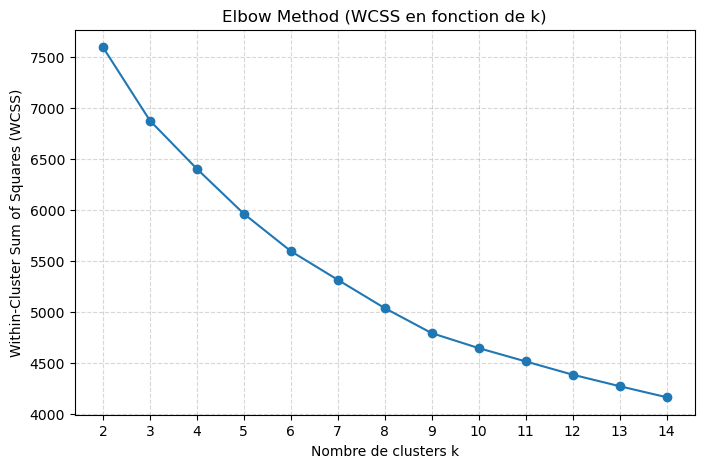

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1) Définir la plage de k à tester
k_grid = range(2, 15)

# 2) Calcul du WCSS pour chaque k
wcss = []
for k in k_grid:
    km = KMeans(
        n_clusters=k,
        init='k-means++',   # initialisation recommandée
        max_iter=300,
        n_init=10,
        random_state=0
    )
    km.fit(X_scaled)
    wcss.append(km.inertia_)

# 3) Tracé de la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(k_grid, wcss, marker='o', linestyle='-')
plt.title('Elbow Method (WCSS en fonction de k)')
plt.xlabel('Nombre de clusters k')
plt.ylabel('Within‑Cluster Sum of Squares (WCSS)')
plt.xticks(k_grid)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
#les deux courbes se ressemblent! Continuons l'exploration

In [13]:
# 1) Vous avez déjà mis à l’échelle :
#    scaler = MinMaxScaler()
#    X_scaled = scaler.fit_transform(X)

# 2) Réduction en 2 composantes sur X_scaled
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)
print(f"PCA réduit de {X.shape[1]} → {pca.n_components_} dimensions")

# 3) Clustering KMeans sur les données projetées
kmeans = KMeans(
    init="k-means++",
    n_clusters=n_digits,
    n_init=4,
    max_iter=300,
    random_state=0
)
kmeans.fit(reduced_data)

# (Re)définition des noms de colonnes si nécessaire
column_names = [f"X{i}" for i in range(X.shape[1])]

# 4) Récupération des labels et création du tableau de contingence
data = pd.DataFrame(X, columns=column_names).assign(label=labels)
data["cluster"] = kmeans.labels_
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table


PCA réduit de 64 → 2 dimensions


label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,0,3,98,0,1,0,0,0,40
1,13,0,0,0,17,7,140,0,0,1
2,0,8,13,12,3,30,0,113,33,9
3,159,0,0,0,0,5,7,0,0,0
4,0,53,10,0,6,44,4,46,55,10
5,0,0,116,42,0,3,0,2,4,5
6,1,0,0,0,149,1,30,1,1,0
7,4,6,4,20,0,47,0,0,7,95
8,1,28,31,11,0,44,0,1,70,20


In [14]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    3
1    6
2    7
3    0
4    8
5    2
6    4
7    9
8    8
9    1
dtype: int32


In [ ]:
# Visualisation T-SNE

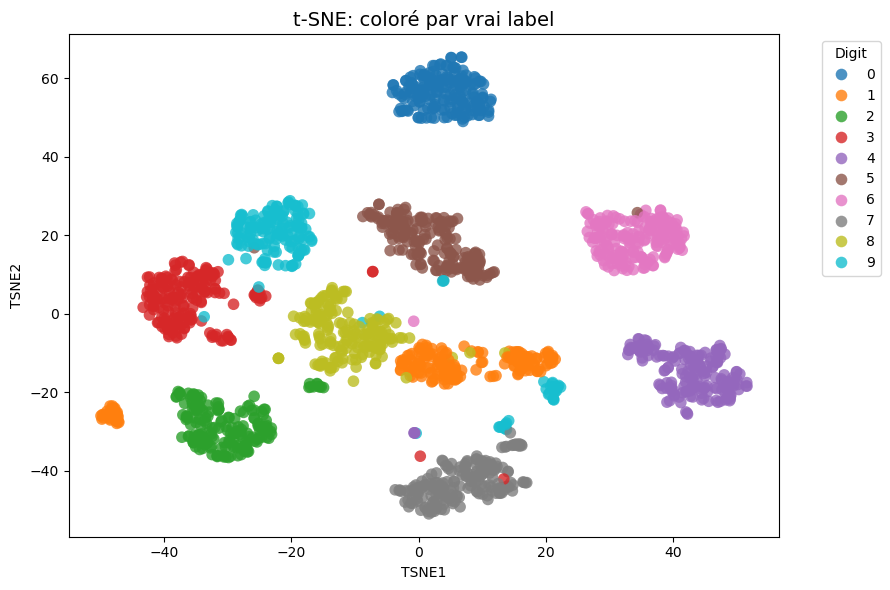

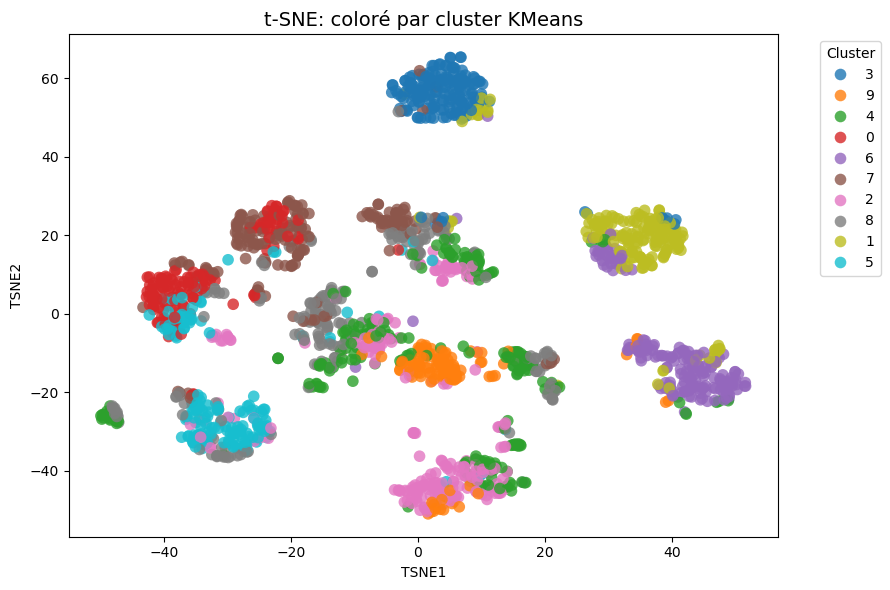

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# On part de X_scaled et kmean_labels déjà calculés
# X_scaled : vos données MinMaxScaler
# kmean_labels : labels issus de kmeans.fit(...)

# 1) Projection t-SNE en 2D
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    metric='euclidean'
)
X_tsne = tsne.fit_transform(X_scaled)

# 2) Construction du DataFrame pour le plot
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label']   = labels.astype(str)       # vrais labels (Digits)
df_tsne['cluster'] = kmean_labels.astype(str) # labels KMeans

# 3) Visualisation par vrai label
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1', y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8, s=70, edgecolor='none'
)
plt.title('t‑SNE: coloré par vrai label', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4) Visualisation par label de cluster
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1', y='TSNE2',
    hue='cluster',
    palette='tab10',
    alpha=0.8, s=70, edgecolor='none'
)
plt.title('t‑SNE: coloré par cluster KMeans', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


En un mot, selon l’objectif, deux approches se dessinent : si l’on cherche avant tout à maximiser la séparation intrinsèque entre les clusters sans supervision, l’association d’un RobustScaler et d’une PCA à deux composantes avant KMeans offre la meilleure silhouette ( 0,47) ; en revanche, pour que les clusters se calquent au mieux sur des labels connus, un MinMaxScaler sans réduction (ou avec PCA à 99 % de variance) reste imbattable en V‑measure ( 0,743) et ARI ( 0,672). Les réglages de KMeans (init, n_init, max_iter) jouent un rôle mineur une fois le pré‑traitement défini, si bien qu’il est plus rentable de concentrer l’effort sur le choix du scaler et, le cas échéant, du degré de réduction dimensionnelle.